In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import datetime
import itertools
import argparse
import collections

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [ ]:
import ee
# # Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='')

## utils

In [ ]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

## Sentinel-2 image downloading

In [ ]:
!pip install geopandas
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 204.9 kB/s eta 0:00:00
  Created wheel for 

In [ ]:
import geopandas
import rasterio
import rasterio.mask

### utils

In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

# Define a function to apply the cloud mask to each image in the collection.
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

def calculate_bounds_from_geojson(geojson):
    """
    this function calculates the top left and bottom right coordinates of a box around a geojson used to download imagery

    Parameters
    ----------
    geojson : dict
        the geojson that describes the spatial information of the farm / area in question.

    Returns
    -------
    bounds : list
        list of tuples that corresponds to lat and long of top left and bottom right coordinates.

    """
    geojson_as_dataframe = geopandas.GeoDataFrame.from_features(geojson)
    bounds = [(geojson_as_dataframe.total_bounds[0], geojson_as_dataframe.total_bounds[1]), (geojson_as_dataframe.total_bounds[2], geojson_as_dataframe.total_bounds[3])]

    return bounds

def convert_bands_2_numpy(s2_sr_median, aoi_vineyard):
    #using the median value of multi bands
    s2_sr_mediana = s2_sr_median.reproject(crs = ee.Projection('EPSG:4326'), scale=10)

    #collect all the available bands over the aoi
    selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
    l8sr_bands = s2_sr_mediana.select(selected_bands).sampleRectangle(aoi_vineyard)

    band_arr = l8sr_bands.get('B1')
    s2_arr = np.array(band_arr.getInfo())

    #stack all bands together
    for idx, band in enumerate(selected_bands):
        if band == 'B1': continue
        band_arr = l8sr_bands.get(band)
        band_arr = np.array(band_arr.getInfo())
        # Stack the individual bands to make a 3-D array.
        s2_arr = np.dstack((s2_arr, band_arr))

    #apply the scale of the image
    s2_array = (s2_arr * 0.0001).astype(np.float32)

    return s2_array

def plot_rgb_image(s2_arr):
    #apply the scale of the image
    s2_array = (s2_arr / 0.0001).astype(np.float32)

    #show RGB image: B4, B3, B2
    rgb_img = s2_array[:,:,1:4]
    rgb_img = rgb_img[:,:,::-1]

    # Scale the data to [0, 255] to show as an RGB image.
    rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
    plt.imshow(rgb_img_test)
    plt.show()

In [ ]:
#setting filtering parameters
CLOUD_FILTER = 60 #integer, Maximum image cloud cover percent allowed in image collection
CLD_PRB_THRESH = 20 #integer, Cloud probability (%); values greater than are considered cloud
NIR_DRK_THRESH = 0.15 #float, Near-infrared reflectance; values less than are considered potential cloud shadow
CLD_PRJ_DIST = 2 #float, Maximum distance (km) to search for cloud shadows from cloud edges
BUFFER = 90 #integer, Distance (m) to dilate the edge of cloud-identified objects

In [ ]:
def get_s2_features_main(geoJSON, vineyard_name, START_DATE, END_DATE):

    #compute the center location of the AOI
    bounds = calculate_bounds_from_geojson(geoJSON)
    #aoi of vineyard
    aoi_vineyard = ee.Geometry.Polygon([[[bounds[0][0], bounds[0][1]],
                                        [bounds[0][0], bounds[1][1]],
                                        [bounds[1][0], bounds[1][1]],
                                        [bounds[1][0], bounds[0][1]]]])

    longitude, latitude = (bounds[0][0] + bounds[1][0])/2, (bounds[0][1] + bounds[1][1])/2
    AOI = ee.Geometry.Point(longitude, latitude)

    # Reassemble the S2-cloudless collection since the collection filter parameters have changed.
    s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
    # Reduce the collection by median
    s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                                .map(apply_cld_shdw_mask)
                                .median())

    #creating downloading file name for single image
    file_name = s2_sr_cld_col.getInfo()['features'][-1]['properties']['DATASTRIP_ID']
    #convert image format
    s2_array = convert_bands_2_numpy(s2_sr_median, aoi_vineyard)

    #compute vegetation indices for each block
    data1 = generate_block_wise_vegetation_indices(s2_array, bounds, geoJSON, vineyard_name, START_DATE, END_DATE)

    return data1, file_name

### s2 noisy time series

In [ ]:
#test parameters
i_date, f_date = '2018-01-01', '2018-12-31'
# r_lon, r_lat = 142.4377389809555, -30.95203025969217
# r_lon, r_lat = 1.0757467083137495, 48.02695618370076
# r_lon, r_lat = 15.291507673637822, 61.554831262246616
# r_lon, r_lat = 11.424320173637822, 44.07288922099584
r_lon, r_lat = -2.022945451362177, 53.160855383911525
scale = 10
selected_features = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
poi = ee.Geometry.Point(r_lon, r_lat)
CloudCoverMax = 20

In [ ]:
# Define the location of interest with a point.
poi = ee.Geometry.Point(r_lon, r_lat)

selected_features = ['B2','B3','B4','B5','B6']
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
    .filterBounds(poi)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CloudCoverMax))
    .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT',CloudCoverMax))
    .select(selected_features)
    .filterDate(ee.Date(i_date), ee.Date(f_date)))

# Evaluate local precipitation conditions.
local_pr = s2.getRegion(poi, scale).getInfo()
pr_df = ee_array_to_df(local_pr, selected_features)

#sentinel bands are in scale of 0.0001
#adjust the scale of the values
pr = np.array(pr_df[selected_features])/10000
prd = pd.DataFrame(pr, columns=selected_features)
prd['datetime'] = pr_df['datetime']
prd

,B2,B3,B4,B5,B6,datetime
0,0.0356,0.0335,0.0323,0.0648,0.1220,2018-01-07 11:14:31.457
1,0.0357,0.0338,0.0322,0.0641,0.1205,2018-01-07 11:14:31.457
2,0.0130,0.0141,0.0167,0.0669,0.1344,2018-02-09 11:22:17.460
3,0.0190,0.0377,0.0344,0.0739,0.1266,2018-02-24 11:22:28.439
4,0.0067,0.0266,0.0248,0.0657,0.1188,2018-02-24 11:22:28.439
5,0.0230,0.0266,0.0320,0.0749,0.1218,2018-04-05 11:21:10.000
6,0.1897,0.2031,0.1931,0.2656,0.3928,2018-04-20 11:26:11.000
7,0.0330,0.0509,0.0415,0.1036,0.1863,2018-05-05 11:23:04.000
8,0.0322,0.0504,0.0413,0.1032,0.1862,2018-05-05 11:23:04.000
9,0.0352,0.0581,0.0564,0.1130,0.2299,2018-05-07 11:08:35.000


In [ ]:
prd

,B2,B3,B4,B5,B6,datetime
0,0.4629,0.4446,0.4711,0.4864,0.5029,2017-01-04 00:34:10.392
1,0.1343,0.1479,0.2332,0.2639,0.2918,2017-01-14 00:33:57.570
2,0.1109,0.1216,0.2135,0.2314,0.2549,2017-01-17 00:43:08.450
3,0.1066,0.1192,0.2023,0.2237,0.2608,2017-01-27 00:42:43.806
4,0.0968,0.0890,0.1245,0.1316,0.1475,2017-02-06 00:43:02.849
5,0.1253,0.1373,0.2276,0.2592,0.2886,2017-02-13 00:34:21.612
6,0.1098,0.1230,0.2149,0.2420,0.2608,2017-02-16 00:42:41.201
7,0.1245,0.1355,0.2295,0.2571,0.2874,2017-02-23 00:30:59.573
8,0.1081,0.1191,0.2025,0.2216,0.2438,2017-03-08 00:40:59.178
9,0.1209,0.1297,0.2145,0.2373,0.2680,2017-03-15 00:31:07.400


In [ ]:
prd

,B2,B3,B4,B5,B6,datetime
0,0.0732,0.1362,0.3012,0.3496,0.3630,2018-12-15 00:35:32.000
1,0.0600,0.1192,0.2706,0.3172,0.3274,2018-12-18 00:45:28.634
2,0.0729,0.1262,0.2814,0.3302,0.3455,2018-12-20 00:35:36.000
3,0.0621,0.1138,0.2678,0.3151,0.3298,2018-12-23 00:45:32.000
4,0.0738,0.1300,0.2966,0.3434,0.3572,2018-12-25 00:35:33.000
5,0.0648,0.1220,0.2832,0.3284,0.3357,2018-12-28 00:45:30.000
6,0.0799,0.1338,0.2952,0.3422,0.3567,2018-12-30 00:35:38.000


In [ ]:
# Evaluate local precipitation conditions.
local_pr = s2.getRegion(poi, scale).getInfo()
pr_df = ee_array_to_df(local_pr, selected_features)
pr_df

,time,datetime,B2,B3,B4,B5,B6
0,1520037421460,2018-03-03 00:37:01.460,1117,1276,2327,2571,2740
1,1520209618460,2018-03-05 00:26:58.460,1258,1416,2470,2655,2880
2,1520469414460,2018-03-08 00:36:54.460,3865,3642,4256,4186,4352
3,1520641623460,2018-03-10 00:27:03.460,1224,1361,2425,2710,2960
4,1520901420460,2018-03-13 00:37:00.460,1556,1662,2648,2972,3161
5,1521073619460,2018-03-15 00:26:59.460,1222,1366,2431,2673,2877
6,1521333417460,2018-03-18 00:36:57.460,1135,1280,2321,2503,2706
7,1521505624460,2018-03-20 00:27:04.460,2565,2532,3288,3435,3667
8,1521765422460,2018-03-23 00:37:02.460,1984,2092,2866,2956,3157
9,1521937622460,2018-03-25 00:27:02.460,1983,1900,2416,2471,2619


In [ ]:
s2_array

array([[[0.1241 , 0.1391 , 0.2429 , 0.2668 , 0.28785]]])

### s2 point values

In [ ]:
#test parameters
i_date, f_date = '2018-03-01', '2018-03-31'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 10
selected_features = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
poi = ee.Geometry.Point(r_lon, r_lat)

In [ ]:
# Reassemble the S2-cloudless collection since the collection filter parameters have changed.
s2_sr_cld_col = get_s2_sr_cld_col(poi, i_date, f_date )
# Reduce the collection by median
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                            .map(apply_cld_shdw_mask))

In [1]:
# Evaluate local precipitation conditions.
local_pr = s2_sr_median.getRegion(poi, scale).getInfo()
pr_df = ee_array_to_df(local_pr, selected_features)

#adjust the scale of the values
pr = np.array(pr_df[selected_features])/10000
prd = pd.DataFrame(pr, columns=selected_features)

In [ ]:
pr_df

,time,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,1544834132000,2018-12-15 00:35:32.000,589,732,1362,3012,3496,3630,3704,3670,3750,3662,5668,4961
1,1545093928634,2018-12-18 00:45:28.634,412,600,1192,2706,3172,3274,3345,3332,3421,3383,5141,4569
2,1545266136000,2018-12-20 00:35:36.000,481,729,1262,2814,3302,3455,3546,3494,3577,3628,5474,5119
3,1545525932000,2018-12-23 00:45:32.000,401,621,1138,2678,3151,3298,3402,3428,3421,3472,5266,4878
4,1545698133000,2018-12-25 00:35:33.000,561,738,1300,2966,3434,3572,3659,3752,3696,3725,5544,4960
5,1545957930000,2018-12-28 00:45:30.000,471,648,1220,2832,3284,3357,3475,3432,3545,3534,5262,4678
6,1546130138000,2018-12-30 00:35:38.000,550,799,1338,2952,3422,3567,3678,3604,3678,3700,5594,5192


In [ ]:
prd

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,0.0589,0.0732,0.1362,0.3012,0.3496,0.3630,0.3704,0.3670,0.3750,0.3662,0.5668,0.4961
1,0.0412,0.0600,0.1192,0.2706,0.3172,0.3274,0.3345,0.3332,0.3421,0.3383,0.5141,0.4569
2,0.0481,0.0729,0.1262,0.2814,0.3302,0.3455,0.3546,0.3494,0.3577,0.3628,0.5474,0.5119
3,0.0401,0.0621,0.1138,0.2678,0.3151,0.3298,0.3402,0.3428,0.3421,0.3472,0.5266,0.4878
4,0.0561,0.0738,0.1300,0.2966,0.3434,0.3572,0.3659,0.3752,0.3696,0.3725,0.5544,0.4960
5,0.0471,0.0648,0.1220,0.2832,0.3284,0.3357,0.3475,0.3432,0.3545,0.3534,0.5262,0.4678
6,0.0550,0.0799,0.1338,0.2952,0.3422,0.3567,0.3678,0.3604,0.3678,0.3700,0.5594,0.5192


### s2 image_feature preparation

In [ ]:
def get_s2_array(r_lon, r_lat, START_DATE, END_DATE):
    # generate bounds
    bounds = [[r_lon+0.001, r_lat+0.001],[r_lon-0.001, r_lat-0.001]]
    #aoi of vineyard
    aoi_vineyard = ee.Geometry.Polygon([[[bounds[0][0], bounds[0][1]],
                                        [bounds[0][0], bounds[1][1]],
                                        [bounds[1][0], bounds[1][1]],
                                        [bounds[1][0], bounds[0][1]]]])

    longitude, latitude = (bounds[0][0] + bounds[1][0])/2, (bounds[0][1] + bounds[1][1])/2
    AOI = ee.Geometry.Point(longitude, latitude)

    # Reassemble the S2-cloudless collection since the collection filter parameters have changed.
    s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
    # Reduce the collection by median
    s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                                .map(apply_cld_shdw_mask)
                                .median())

    #creating downloading file name for single image
    file_name = s2_sr_cld_col.getInfo()['features'][-1]['properties']['DATASTRIP_ID']
    #convert image format
    s2_array = convert_bands_2_numpy(s2_sr_median, aoi_vineyard)

    return s2_array

def get_s2_band_features(s2_array, selected_bands, indexnams):
    central_row, central_col = int(s2_array.shape[0]/2), int(s2_array.shape[1]/2)
    #find the central point
    if s2_array.shape[0]%2 == 0:
        central_row = int(s2_array.shape[0]/2)
    else:
        central_row = int(s2_array.shape[0]/2)+1

    if s2_array.shape[1]%2 == 0:
        central_col = int(s2_array.shape[1]/2)
    else:
        central_col = int(s2_array.shape[1]/2)+1
    #generate vegetation indices
    imdat = VegIndicesarrayL2A(s2_array[central_row:central_row+1,central_col:central_col+1,:])

    #generate band values
    # selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
    s2_band_values = s2_array[central_row:central_row+1,central_col:central_col+1,:]
    s2_bands = pd.DataFrame(np.array(s2_band_values.flatten()).reshape([1,-1]), columns = selected_bands)

    return s2_bands

In [ ]:
s2_features

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,...,N2NDVI,RENDVI1,RENDVI2,RDVI1,RDVI2,TDVI,TDVI2,NLI,LAIG,SM
0,0.0186,0.0339,0.0607,0.0434,0.0984,0.2559,0.32025,0.3532,0.34195,0.32755,...,0.77475,0.564216,0.553083,0.491932,0.77475,0.568507,0.551097,0.483795,2.875412,0.45424


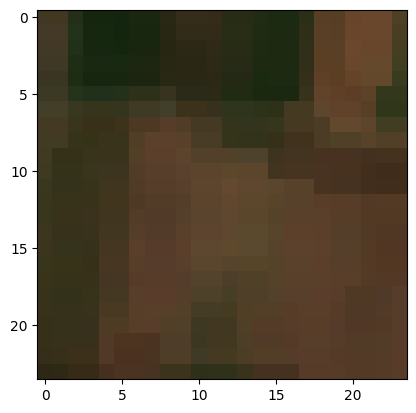

In [ ]:
plot_rgb_image(s2_array)

## s2 time series download

In [ ]:
def get_s2_pointwise_band_values(r_lon, r_lat, scale, i_date, f_date, selected_bands):
    CloudCoverMax = 20
    # selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)

    # selected_features = ['B2','B3','B4','B5','B6']
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(poi)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CloudCoverMax))
        .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT',CloudCoverMax))
        .select(selected_bands)
        .filterDate(i_date, f_date)
        .median())

    #get the metadata of the band
    s2_band_vals = s2.sample(poi, scale).first().getInfo()
    #reorder the band values referencing selected_bands
    df = pd.DataFrame(s2_band_vals['properties'], index=['i',])

    #sentinel bands are in scale of 0.0001
    s2_array = np.array(df[selected_bands])/10000
    #reshape file
    s2_array = s2_array.reshape([1,1,-1])

    return s2_array

### test example

In [ ]:
i_date, f_date = '2018-01-01', '2018-12-31'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 10
CloudCoverMax = 20
selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

s2_array = get_s2_pointwise_band_values(r_lon, r_lat, scale, i_date, f_date, selected_bands)
s2_array, s2_array.shape

(array([[[0.0476 , 0.06885, 0.1241 , 0.2823 , 0.3293 , 0.3406 , 0.35105,
          0.3463 , 0.3561 , 0.3581 , 0.537  , 0.4919 ]]]),
 (1, 1, 12))

## Sentinel-2 time series

We also calculated the 10th and
90th percentile NDVI composites for each year in an attempt to characterize vegetation phenologies (e.g. annual grasses versus perennial
woody plants).

### point based

In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
def get_s2_time_series(r_lon, r_lat, scale, selected_features, i_date, f_date):
    CloudCoverMax = 20
    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(poi)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CloudCoverMax))
        .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT',CloudCoverMax))
        .select(selected_features)
        .filterDate(i_date, f_date))

    #get the metadata of the band
    local_pr = s2.getRegion(poi, scale).getInfo()
    pr_df = ee_array_to_df(local_pr, selected_features)

    pr = np.array(pr_df[selected_features])/10000
    prd = pd.DataFrame(pr, columns=selected_features)

    return prd

def get_s2_statistic_features(prd):
    dfcd = prd.describe()
    dfc_mean = dfcd.loc[['mean']].reset_index(drop=True)
    dfc_std = dfcd.loc[['std']].reset_index(drop=True)
    dfc_25p = dfcd.loc[['25%']].reset_index(drop=True)
    dfc_50p = dfcd.loc[['50%']].reset_index(drop=True)
    dfc_75p = dfcd.loc[['75%']].reset_index(drop=True)

    dfc_mean.rename(update_dictionary_mean, axis=1, inplace=True)
    dfc_std.rename(update_dictionary_std, axis=1, inplace=True)
    dfc_25p.rename(update_dictionary_25p, axis=1, inplace=True)
    dfc_50p.rename(update_dictionary_50p, axis=1, inplace=True)
    dfc_75p.rename(update_dictionary_75p, axis=1, inplace=True)

    dfs2 = pd.concat([dfc_25p, dfc_50p, dfc_75p, dfc_mean, dfc_std], axis=1)

    return dfs2

In [ ]:
i_date, f_date = '2018-01-01', '2018-12-31'
r_lon, r_lat = 15.291507673637822, 61.554831262246616
scale = 10
CloudCoverMax = 20
selected_features = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

In [ ]:
get_s2_time_series(r_lon, r_lat, scale, selected_features, i_date, f_date)

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,0.5875,0.4812,0.4173,0.4150,0.4205,0.4902,0.4611,0.5371,0.4738,0.5571,0.0278,0.0237
1,0.6237,0.5073,0.4763,0.4568,0.5055,0.5483,0.5208,0.5840,0.5424,0.5862,0.0819,0.0775
2,0.7154,0.7058,0.6989,0.6763,0.6927,0.7181,0.7101,0.6740,0.6801,0.6534,0.0664,0.0545
3,0.6838,0.6832,0.6690,0.6632,0.6458,0.6566,0.6438,0.6738,0.5927,0.6389,0.0719,0.0612
4,0.7489,0.6655,0.6711,0.6474,0.6725,0.6957,0.6238,0.6380,0.5923,0.6221,0.0406,0.0302
5,0.7187,0.6521,0.6721,0.6568,0.6590,0.6573,0.6045,0.6421,0.5555,0.5964,0.0331,0.0224
6,0.7647,0.6335,0.6543,0.6214,0.6718,0.6775,0.6007,0.6110,0.5617,0.6025,0.0275,0.0178
7,0.0288,0.0243,0.0374,0.0459,0.0976,0.1595,0.1839,0.2057,0.2137,0.2164,0.1696,0.0933
8,0.0167,0.0297,0.0399,0.0501,0.1021,0.1615,0.1889,0.2163,0.2145,0.2158,0.1857,0.1059
9,0.0199,0.0266,0.0441,0.0521,0.0999,0.1662,0.1885,0.2171,0.2200,0.2167,0.1882,0.1075


### Image download

'B3_25p','B3_50p','B12_75p',

In [ ]:
def get_s2_time_series_images(aoi, image_source, target_band, i_date, f_date, scale):
    # Load a collection
    CloudCoverMax = 20
    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)
    TERRA = (ee.ImageCollection(image_source)
        .filterBounds(aoi)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CloudCoverMax))
        .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT',CloudCoverMax))
        .select(target_band)
        .filterDate(i_date, f_date))

    # Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        #reproject image with user defined scale
        Terra_img = Terra_img.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

        # check if image footprint contains the AOI
        image_footprint = Terra_img.geometry()
        if image_footprint.contains(aoi).getInfo():
            sample = Terra_img.select(target_band).sampleRectangle(region=aoi, defaultValue=0)
            numpy_array_new = np.array(sample.get(target_band).getInfo())
            numpy_array.append(numpy_array_new)
        else:
            print(f"Image {i} does not contain the AOI")
    numpy_array = np.array(numpy_array)
    return numpy_array

In [ ]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
i_date, f_date = '2018-01-01', '2018-12-31'
scale = 10

image_source = 'COPERNICUS/S2_SR'

In [ ]:
#download selected bands
target_band = 'B3'
s2band = get_s2_time_series_images(aoi, image_source, target_band, i_date, f_date, scale)
#replace 0 with nan
s2band = s2band.astype(float)
s2band[s2band == 0] = np.nan
#compute quantile
s2band25p = np.nanquantile(s2band, 0.25, axis=0)
s2band50p = np.nanquantile(s2band, 0.5, axis=0)

#save the results
# np.save(path + 'gee2Ddata/s2band50p.npy', s2band50p)
# np.save(path + 'gee2Ddata/s2band25p.npy', s2band25p)

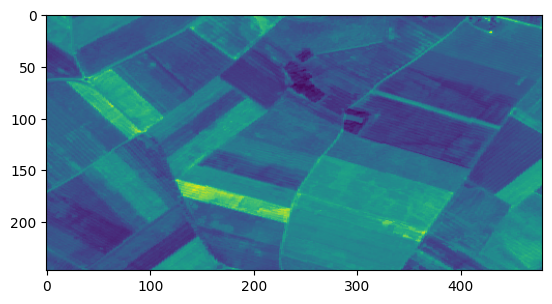

In [ ]:
plt.imshow(s2band25p)